In [118]:
import pickle
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier

from emissions_transformer import EmissionsTransformer

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def load_data(database_filepath):
    """Loads the data from a database file and returns the target."""

    engine = create_engine(f'sqlite:///{database_filepath}')
    df = pd.read_sql_table('emissions', engine)

    return df

In [43]:
df = load_data('../data/emissions.db')

In [44]:
def split_data(df):


    df_pop = df.dropna(subset=['tax_band'])
    X_pop = df_pop.drop(columns='tax_band')
    y_pop = df_pop['tax_band']

    df_nan = df[df['tax_band'].isnull()]
    X_nan = df_nan.drop(columns='tax_band')

    return X_pop, y_pop, X_nan

In [45]:
X_pop, y_pop, X_nan = split_data(df)

In [46]:
def load_model(filepath):
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
        
    return model

In [47]:
model = load_model('./classifier.pkl')

In [48]:
model.best_params_

{'clf__criterion': 'entropy'}

In [49]:
tf = EmissionsTransformer()
X_tf = tf.transform(X_pop)

In [51]:
clf = RandomForestClassifier(criterion="entropy")
clf.fit(X_tf, y_pop)

RandomForestClassifier(criterion='entropy')

In [52]:
clf.feature_importances_

array([1.96723598e-03, 1.48413367e-03, 6.27638717e-02, 2.16725806e-01,
       1.51050678e-02, 3.04979034e-01, 1.32212465e-02, 2.08433750e-02,
       3.26039618e-02, 1.03265870e-02, 2.25409504e-01, 1.53643882e-04,
       5.01347325e-04, 1.11938800e-03, 2.87157721e-03, 4.12386808e-04,
       8.56844960e-04, 8.41252028e-04, 3.51935334e-04, 1.40303475e-03,
       1.13810262e-03, 5.66021323e-04, 1.28154671e-04, 1.19408789e-03,
       3.27089855e-04, 1.98342802e-04, 4.31534413e-04, 2.90754486e-03,
       3.66149183e-04, 6.02746039e-04, 5.13226190e-04, 2.55663998e-03,
       1.05943281e-03, 2.26812366e-03, 9.42764313e-04, 3.22032996e-04,
       8.96353115e-04, 6.29890932e-04, 5.52968702e-04, 4.41177312e-04,
       8.03635721e-04, 1.54111792e-03, 2.92232867e-03, 1.81155054e-03,
       5.69244016e-04, 5.75669475e-04, 7.07049232e-04, 8.65728116e-04,
       3.32190117e-04, 2.12978578e-03, 3.19500175e-03, 2.30646954e-03,
       1.79329909e-03, 2.95709284e-04, 3.91892627e-04, 4.30897746e-04,
      

In [55]:
X_tf.shape, len(clf.feature_importances_)


((7837, 72), 72)

In [102]:
fi = pd.Series(data=clf.feature_importances_, index=X_tf.columns)

In [103]:
fi.sort_values(ascending=False).head(10)

co2                       0.304979
fuel_cost_12000_miles     0.225410
combined_metric           0.216726
engine_capacity           0.062764
nox_emissions             0.032604
co_emissions              0.020843
noise_level               0.015105
thc_emissions             0.013221
fuel_type_Diesel          0.010566
particulates_emissions    0.010327
dtype: float64

In [104]:
fi.sum()

1.0

In [105]:
mf_index = [x for x in fi.index.values if 'manufacturer' in x]
fi[mf_index].sum()

0.033632426807453174

In [106]:
ft_index = [x for x in fi.index.values if 'fuel_type' in x]
fi[ft_index].sum()

0.02210744923294577

In [107]:
tm_index = [x for x in fi.index.values if 'transmission' in x and 'transmission_type' not in x]
fi[tm_index].sum()

0.02975829698713395

In [108]:
tmt_index = [x for x in fi.index.values if 'transmission_type' in x]
fi[tmt_index].sum()

0.009072002875581166

In [109]:
fi_new = fi.copy()
fi_new.drop(labels=mf_index, inplace=True)
fi_new.drop(labels=ft_index, inplace=True)
fi_new.drop(labels=tm_index, inplace=True)
fi_new.drop(labels=tmt_index, inplace=True)
fi_new['manufacturer'] = fi[mf_index].sum()
fi_new['fuel_type'] = fi[ft_index].sum()
fi_new['transmission'] = fi[tm_index].sum()
fi_new['transmission_type'] = fi[tmt_index].sum()


In [110]:
fi_new

year                      0.001967
euro_standard             0.001484
engine_capacity           0.062764
combined_metric           0.216726
noise_level               0.015105
co2                       0.304979
thc_emissions             0.013221
co_emissions              0.020843
nox_emissions             0.032604
particulates_emissions    0.010327
fuel_cost_12000_miles     0.225410
manufacturer              0.033632
fuel_type                 0.022107
transmission              0.029758
transmission_type         0.009072
dtype: float64

In [111]:
fi_new.sum()

1.0

In [113]:
fi_new.sort_values(ascending=False)

co2                       0.304979
fuel_cost_12000_miles     0.225410
combined_metric           0.216726
engine_capacity           0.062764
manufacturer              0.033632
nox_emissions             0.032604
transmission              0.029758
fuel_type                 0.022107
co_emissions              0.020843
noise_level               0.015105
thc_emissions             0.013221
particulates_emissions    0.010327
transmission_type         0.009072
year                      0.001967
euro_standard             0.001484
dtype: float64

<AxesSubplot:ylabel='None'>

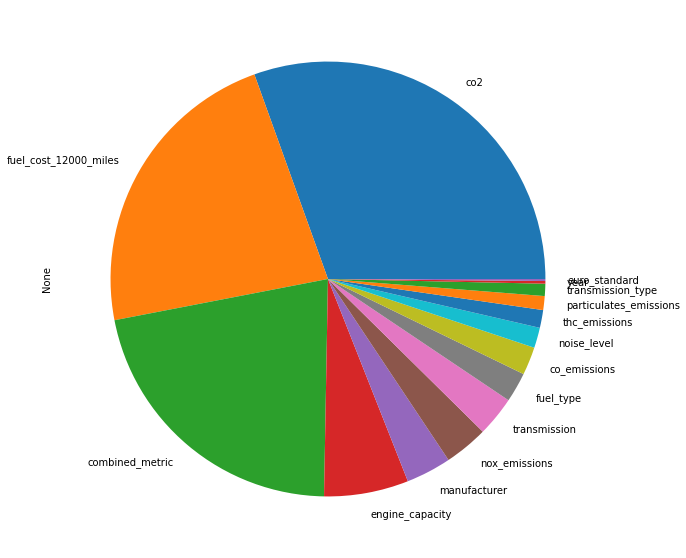

In [119]:
plt.figure(figsize=(10,10)) 
fi_new.sort_values(ascending=False).plot.pie()